<a href="https://colab.research.google.com/github/19-ade/19-ade/blob/main/UCI_data_15_6_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Accelerometer Biometric data and analysis [Link to Data](https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer#)
---



In [ ]:
! pip install torchlibrosa
! pip install pytorch_lightning


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchlibrosa.stft import Spectrogram, LogmelFilterBank
from torchlibrosa.augmentation import SpecAugmentation
from collections import Counter, defaultdict
import matplotlib.pyplot as plt 
import pytorch_lightning as pl
import os 
import scipy 

#from pytorch_lightning.metrics.functional import accuracy

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [38]:
''' Rules: ( see Manual.txt)

Type:		   tri-axial accelerometer
Measurement range: [- 1.5g; + 1.5g]
Sensitivity: 	   6 bits per axis
Output data rate:  32 Hz
Location:	   attached to the right wrist of the user with:
		   - x axis: pointing toward the hand
		   - y axis: pointing toward the left
		   - z axis: perpendicular to the plane of the hand


Acceleration data recorded in the dataset are coded according to the following mapping:
	[0; +63] = [-1.5g; +1.5g]
The conversion rule to extract the real acceleration value from the coded value is the following:
	real_val = -1.5g + (coded_val/63)*3g


Each file in the dataset follows the following naming convention:
Accelerometer-[START_TIME]-[HMP]-[VOLUNTEER]
where:
- [START_TIME]: timestamp of the starting moment of the recording
		in the format [YYYY-MM-DD-HH-MM-SS]
- [HMP]:	name of the HMP performed in the recorded trial, following
		the naming convention specified in Section 2 of this manual
- [VOLUNTEER]:	identification code of the volunteer performing the recorded
		motion in the format [gN] where:
		- "g" indicates the gender of the volunteer
		  (m -> male, f -> female)
		- "N" indicates the progressive number associated to the
		  volunteer

For example the file:
	Accelerometer-2011-03-24-10-24-39-climb_stairs-f1.txt
refers to an accelerometer recording that was taken on March 24, 2011, starting from 10:24.39 a.m.. 
The recording refers to the HMP "climb_stairs" executed by the volunteer with ID "f1".



'''
PATH = "/content/gdrive/MyDrive/UCI_data /HMP_Dataset/dataset.csv"

class Make_DataFrame:
  def __init__(self):
    self.df = pd.DataFrame()

  def col_identifier(self, file_name):
    # extracting the class and subject_id from 
    # file name
    name_ls = file_name.split('/')[-1].split('-')
    cl = name_ls[-2]
    v_id = name_ls[-1].split('.')[0]
    date_starting_time = "-".join(name_ls[1:-2])
    return (v_id, cl, date_starting_time)
  
  def dataframe_maker(self, file_name):
    # Reading the files 
    df1 = pd.read_csv(file_name, sep = " ", header = None, names = ['X', 'Y',
                                                                    'Z'])
    # Adding the id, class and date columns
    col_return = self.col_identifier(file_name)
    df1[['subject_id', 'cat', 'date_time']] = [col_return[0], col_return[1],
                                                     col_return[2]]
    
    # Converting acc data to acceleration
    df1.X = self.calc_acc(df1.X.values)
    df1.Y = self.calc_acc(df1.Y.values)
    df1.Z = self.calc_acc(df1.Z.values)

    # Appending to dataframe object
    if len(self.df)==0:
      self.df = df1
    else:
      self.df = self.df.append(df1, ignore_index=True)

  def calc_acc(self, data):
    # calculating the acceleration form the 
    return -14.709 + (data/63)*(2*14.709)

  def store_file(self):
    # save the dataset as csv in gdrive
    with open(PATH, 'w', encoding = 'utf-8-sig') as f:
      self.df.to_csv(f, index_label=False)

  


In [40]:
# looping over the folders 
# extracting classes and data 

DIR_LOC = "/content/gdrive/MyDrive/UCI_data /HMP_Dataset"
a = Make_DataFrame()
for folder in os.listdir(DIR_LOC):
  if folder.split('_')[-1] == 'MODEL':
    continue
  else:
    file_list_loc = DIR_LOC + "/" + folder
    print(file_list_loc)
    for file in os.listdir(file_list_loc):
      a.dataframe_maker(file_list_loc+"/"+file)
      #print(a.df)

/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Pour_water
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Climb_stairs
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Sitdown_chair
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Use_telephone
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Walk
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Standup_chair
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Descend_stairs
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Brush_teeth
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Liedown_bed
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Eat_meat
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Drink_glass
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Getup_bed
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Comb_hair
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Eat_soup
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/.ipynb_checkpoints


In [33]:
a.df.head()

,X,Y,Z,subject_id,cat,date_time
0,2.101286,5.836905,7.704714,f1,pour_water,2011-03-24-10-51-12
1,2.101286,5.836905,7.704714,f1,pour_water,2011-03-24-10-51-12
2,2.568238,5.369952,8.171667,f1,pour_water,2011-03-24-10-51-12
3,2.101286,5.836905,8.638619,f1,pour_water,2011-03-24-10-51-12
4,2.101286,5.369952,8.171667,f1,pour_water,2011-03-24-10-51-12


In [41]:
# save the file in the gdrive folder

a.store_file()

In [53]:
# load dataset from folder 
PATH_TO_DATASET = '/content/gdrive/MyDrive/UCI_data /HMP_Dataset/dataset.csv' # change this 

df1 = pd.read_csv(PATH_TO_DATASET)
df1.subject_id.unique()

array(['f1', 'm2', 'f4', 'm1', 'm9', 'f2', 'm3', 'f3', 'm4', 'm11', 'm5',
       'm6', 'm7', 'm8', 'm10', 'f5'], dtype=object)

In [51]:
df1.head()

,X,Y,Z,subject_id,cat,date_time
0,2.101286,5.836905,7.704714,f1,pour_water,2011-03-24-10-51-12
1,2.101286,5.836905,7.704714,f1,pour_water,2011-03-24-10-51-12
2,2.568238,5.369952,8.171667,f1,pour_water,2011-03-24-10-51-12
3,2.101286,5.836905,8.638619,f1,pour_water,2011-03-24-10-51-12
4,2.101286,5.369952,8.171667,f1,pour_water,2011-03-24-10-51-12


In [44]:
df1.cat.unique()

array(['pour_water', 'climb_stairs', 'sitdown_chair', 'use_telephone',
       'walk', 'standup_chair', 'descend_stairs', 'brush_teeth',
       'liedown_bed', 'eat_meat', 'drink_glass', 'getup_bed', 'comb_hair',
       'eat_soup'], dtype=object)

In [45]:
for i in df1.columns:
  print(df1[i].isna().sum())

0
0
0
0
0
0


In [46]:
df1.describe()

,X,Y,Z
count,446529.000000,446529.000000,446529.000000
mean,-3.188558,3.137682,4.828214
std,5.677017,3.591185,3.877309
min,-14.709000,-14.709000,-14.709000
25%,-8.638619,1.634333,1.634333
50%,-3.035190,3.035190,4.903000
75%,1.167381,4.903000,8.638619
max,14.709000,14.709000,14.709000


In [47]:
df1.describe

<bound method NDFrame.describe of                X         Y         Z subject_id         cat  \
0       2.101286  5.836905  7.704714         f1  pour_water   
1       2.101286  5.836905  7.704714         f1  pour_water   
2       2.568238  5.369952  8.171667         f1  pour_water   
3       2.101286  5.836905  8.638619         f1  pour_water   
4       2.101286  5.369952  8.171667         f1  pour_water   
...          ...       ...       ...        ...         ...   
446524  1.634333  7.704714  6.770810         f1    eat_soup   
446525  1.634333  7.704714  6.770810         f1    eat_soup   
446526  1.634333  6.770810  6.303857         f1    eat_soup   
446527  1.634333  7.237762  6.770810         f1    eat_soup   
446528  1.634333  8.171667  6.770810         f1    eat_soup   

                  date_time  
0       2011-03-24-10-51-12  
1       2011-03-24-10-51-12  
2       2011-03-24-10-51-12  
3       2011-03-24-10-51-12  
4       2011-03-24-10-51-12  
...                     ...  

In [50]:
# category and sequence stats 
l = []
c = {key: None for key in df1.cat.unique()}
for i in df1.date_time.unique():
  l.append(len(df1[df1['date_time']==i]))
  cat = df1[df1['date_time']==i]['cat'].unique()[0]
  if c[cat]==None:
     c[cat] = [len(df1[df1['date_time']==i])]
  else:
    c[cat].append(len(df1[df1['date_time']==i]))
print("Sequence: \n")
print(f"Avg length : {np.mean(l):.2f}")
print(f"Max length : {np.max(l)}")
print(f"Min length : {np.min(l)}")
print(f"Median length : {np.median(l)}\n")

print("Cat: \n")
for key, value in c.items():
  print(f"Cat: {key}")
  print(f"Mean: {np.mean(c[key]):.2f}, Max: {np.max(c[key])}, MIn: {np.min(c[key])}, Median: {np.median(c[key])}")



Sequence: 

Avg length : 532.22
Max length : 9318
Min length : 125
Median length : 403.0

Cat: 

Cat: pour_water
Mean: 416.73, Max: 810, MIn: 244, Median: 406.0
Cat: climb_stairs
Mean: 394.69, Max: 805, MIn: 166, Median: 402.5
Cat: sitdown_chair
Mean: 250.36, Max: 691, MIn: 125, Median: 210.0
Cat: use_telephone
Mean: 1171.15, Max: 2857, MIn: 333, Median: 995.0
Cat: walk
Mean: 922.54, Max: 3153, MIn: 187, Median: 914.0
Cat: standup_chair
Mean: 249.19, Max: 545, MIn: 141, Median: 205.5
Cat: descend_stairs
Mean: 366.07, Max: 594, MIn: 156, Median: 363.5
Cat: brush_teeth
Mean: 2485.75, Max: 3199, MIn: 844, Median: 2484.5
Cat: liedown_bed
Mean: 408.79, Max: 736, MIn: 212, Median: 400.0
Cat: eat_meat
Mean: 6247.20, Max: 9318, MIn: 4251, Median: 5859.0
Cat: drink_glass
Mean: 427.92, Max: 1322, MIn: 255, Median: 376.0
Cat: getup_bed
Mean: 453.48, Max: 769, MIn: 256, Median: 454.0
Cat: comb_hair
Mean: 758.19, Max: 1282, MIn: 403, Median: 753.0
Cat: eat_soup
Mean: 2227.67, Max: 2300, MIn: 2150, 

In [49]:
for i in df1.cat.unique():
  print(f"class:{i}, length:{len(df1[df1['cat']==i]['date_time'].unique())}")

class:pour_water, length:100
class:climb_stairs, length:102
class:sitdown_chair, length:100
class:use_telephone, length:13
class:walk, length:100
class:standup_chair, length:102
class:descend_stairs, length:42
class:brush_teeth, length:12
class:liedown_bed, length:28
class:eat_meat, length:5
class:drink_glass, length:100
class:getup_bed, length:101
class:comb_hair, length:31
class:eat_soup, length:3


In [14]:
''' Characteristics of the data : no sequence starting date and time has been 
repeated. 
Implemented :

Cleaning:
median Filtering 

time domain: 
max
mean
std

freq domain:
FFT 
Spectrogram 
power spectral analysis 

Todo:
select the correct classes for equal time sampling 
Spectroscope : mel filters 
band pass filtering

'''
class PreProcessing:
  def __init__(self, data):
    self.df = data
    self.dev_x_timed = defaultdict(list) # time_data amplitude
    self.dev_y_timed = defaultdict(list)
    self.dev_z_timed = defaultdict(list)
    self.x_fft_cat = defaultdict(list) # fft 
    self.y_fft_cat = defaultdict(list)
    self.z_fft_cat = defaultdict(list)
    self.x_spec_cat = defaultdict(list) # spectroscope data 
    self.y_spec_cat = defaultdict(list)
    self.z_spec_cat = defaultdict(list)
    self.x_PSD_cat = defaultdict(list) # PSD data []
    self.y_PSD_cat = defaultdict(list)
    self.z_PSD_cat = defaultdict(list)

  def plot_data(self,ylabel, xlabel, title, data, typedata="slice", col=""):
    plt.ylim([-15, 15])
    if typedata=='slice':
      plt.xlim([0, len(data)])
      plt.plot(data)
    elif typedata=='sequence':
      plt.xlim([0, len(data[col])])
      plt.plot(data[col].values)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.show()

  def remove_noise(self, data): # applying median filter 
    kernel_size = 3 # size of the filter 
    return scipy.signal.medfilt(data.values, kernel_size = 
                                               kernel_size)

  def sequence_cleaner(self):
    # clean sequence for each cat    
    for i in self.iterator_generator('seq'):
      self.df.loc[self.df['date_time']==i, 'X'] = self.remove_noise(self.df[self.df['date_time']
                                                                   ==i]['X'])
      self.df.loc[self.df['date_time']==i, 'Y'] = self.remove_noise(self.df[self.df['date_time']
                                                                   ==i]['Y'])                                                                      
      self.df.loc[self.df['date_time']==i, 'Z'] = self.remove_noise(self.df[self.df['date_time']
                                                                   ==i]['Z'])
      
  def calc_time_domain(self, sample):
    mean_x, mean_y, mean_z = sample['X'].mean(), sample['Y'].mean(), sample['Z'].mean()
    std_x, std_y, std_z = sample['X'].std(), sample['Y'].std(), sample['Z'].std()
    max_x, max_y, max_z = sample['X'].max(), sample['Y'].max(), sample['Z'].max()
    id = sample.cat.unique()[0]
    self.dev_x_timed[id].append([mean_x, std_x, max_x])
    self.dev_y_timed[id].append([mean_y, std_y, max_y])
    self.dev_z_timed[id].append([mean_z, std_z, max_z])
  
  def calc_fft(self, data):
    
    yf = scipy.fftpack.fft(data.values)
    xf = scipy.fftpack.fftfreq(len(data), d =1/32)
    
    return [yf[:len(xf)//2+1], xf[:len(xf)//2+1]]
  
  def plot_FFT(self, cat, pos, axis):
    if axis=='X':
      xf = self.x_fft_cat[cat][pos][-1]
      yf = self.x_fft_cat[cat][pos][0]
    if axis=='Y':
      xf = self.y_fft_cat[cat][pos][-1]
      yf = self.y_fft_cat[cat][pos][0]
    if axis=='Z':
      xf = self.z_fft_cat[cat][pos][-1]
      yf = self.z_fft_cat[cat][pos][0]
    
    plt.plot(xf, np.abs(yf))
    plt.grid()
    plt.title(cat)
    plt.xlim([0, np.max(xf)])
    plt.ylabel('Amplitude')
    plt.xlabel('Frequency[Hz]');
    plt.show()

  def feature_extraction(self):
    for i in self.iterator_generator('seq'):
      data_X = self.df[self.df['date_time']==i]['X']
      data_Y = self.df[self.df['date_time']==i]['Y']
      data_Z = self.df[self.df['date_time']==i]['Z']
      
      # Time domain 
      self.calc_time_domain(self.df[self.df['date_time']==i])

      #Freq Domain 
      #FFT 
      self.x_fft_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.calc_fft(data_X))
      
      self.y_fft_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.calc_fft(
          data_Y
      ))
      self.z_fft_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.calc_fft(
          data_Z
      ))

      # Spectrogram 
      self.x_spec_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.Spectrogram_maker(data_X))
      self.y_spec_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.Spectrogram_maker(data_Y))
      self.z_spec_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.Spectrogram_maker(data_Z))
      
      # PSD
      self.x_PSD_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.PSD_maker(data_X))
      self.y_PSD_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.PSD_maker(data_Y))
      self.z_PSD_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.PSD_maker(data_Z))
      

  def PSD_plotter(self, cat, pos, axis):
    if axis=='X':
      f = self.x_PSD_cat[cat][pos][0]
      Pxx_den = self.x_PSD_cat[cat][pos][-1]
    if axis=='Y':
      f = self.y_PSD_cat[cat][pos][0]
      Pxx_den = self.y_PSD_cat[cat][pos][-1]
    if axis=='Z':
      f = self.z_PSD_cat[cat][pos][0]
      Pxx_den = self.z_PSD_cat[cat][pos][-1]
    
    plt.semilogy(f, Pxx_den)
    plt.grid()
    plt.title(cat)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()
  
  def PSD_maker(self, data):
    f, Pxx_den = scipy.signal.welch(data, fs=32, nperseg=128, window = 'hanning')
    return [f, Pxx_den]

  def Spectrogram_maker(self, data):
     freqs, times, Sx = scipy.signal.spectrogram(data, fs=32, window='hanning',
                                          nperseg = 128,
                                          scaling='spectrum')
     return [freqs, times, Sx]
  
  def Spectrogram_plotter(self,cat, pos, axis):
    if axis=='X':
      freqs = self.x_spec_cat[cat][pos][0]
      times = self.x_spec_cat[cat][pos][1]
      Sx = self.x_spec_cat[cat][pos][2]
    if axis=='Y':
      freqs = self.y_spec_cat[cat][pos][0]
      times = self.y_spec_cat[cat][pos][1]
      Sx = self.y_spec_cat[cat][pos][2]
    if axis=='Z':
      freqs = self.z_spec_cat[cat][pos][0]
      times = self.z_spec_cat[cat][pos][1]
      Sx = self.z_spec_cat[cat][pos][2]
    plt.pcolormesh(times, freqs , np.log10(Sx), cmap='viridis')
    plt.colorbar()
    plt.title(cat)
    plt.ylabel('Frequency [Hz] (log10(Power spectrum))')
    plt.xlabel('Time [s]')
    
    plt.show()

  def iterator_generator(self, it):
    seq_lst = self.df['date_time'].unique()
    id_lst = self.df['subject_id'].unique()
    cat_lst = self.df['cat'].unique()
    if it=='seq':
      return seq_lst
    elif it=='id':
      return id_lst
    elif it=='cat':
      return cat_lst

In [15]:
b = PreProcessing(df1)

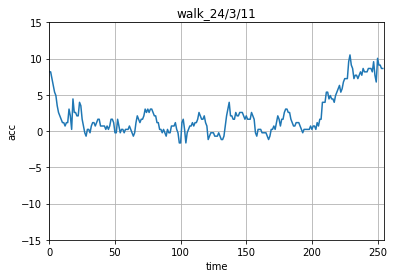

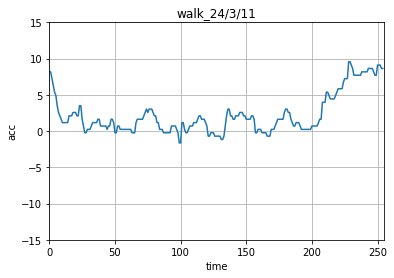

In [16]:
# Testing the process 
# raw data plot 
b.plot_data("acc", "time", "walk_24/3/11",df1[(df1['date_time']=='2011-03-24-11-20-24') & (df1['cat']=='walk')]['Z'].values)
# clean data 
a = b.remove_noise(df1[(df1['date_time']=='2011-03-24-11-20-24') & (df1['cat']=='walk')]['Z'])
b.plot_data("acc", "time", "walk_24/3/11", a)


In [17]:
# sequential cleaning of data (2min processing time)
b.sequence_cleaner()

In [18]:
b.df


,Unnamed: 0,X,Y,Z,subject_id,cat,date_time
0,0,2.101286,5.836905,7.704714,f1,pour_water,2011-03-24-10-51-12
1,1,2.101286,5.836905,7.704714,f1,pour_water,2011-03-24-10-51-12
2,2,2.101286,5.836905,8.171667,f1,pour_water,2011-03-24-10-51-12
3,3,2.101286,5.369952,8.171667,f1,pour_water,2011-03-24-10-51-12
4,4,2.101286,5.836905,8.171667,f1,pour_water,2011-03-24-10-51-12
...,...,...,...,...,...,...,...
446524,446524,1.634333,7.704714,6.770810,f1,eat_soup,2011-03-24-13-56-42
446525,446525,1.634333,7.704714,6.770810,f1,eat_soup,2011-03-24-13-56-42
446526,446526,1.634333,7.237762,6.770810,f1,eat_soup,2011-03-24-13-56-42
446527,446527,1.634333,7.237762,6.770810,f1,eat_soup,2011-03-24-13-56-42


In [19]:
# extracting features 

b.feature_extraction()


/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 128 is greater than input length  = 125, using nperseg = 125
  .format(nperseg, input_length))


In [20]:
b.x_fft_cat['brush_teeth'][2][-1]

array([ 0.00000000e+00,  1.43626571e-02,  2.87253142e-02, ...,
        1.59712747e+01,  1.59856373e+01, -1.60000000e+01])

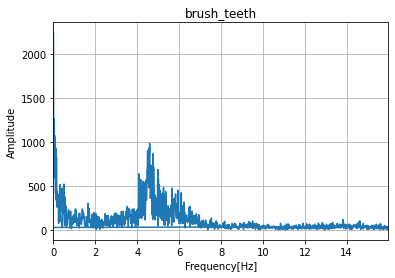

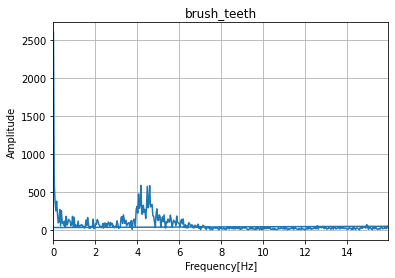

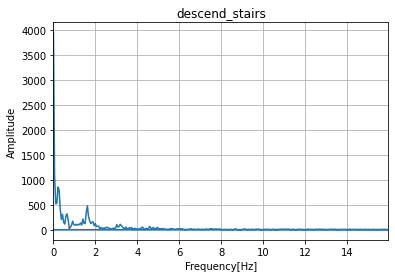

In [21]:
b.plot_FFT('brush_teeth', 2, 'X')
b.plot_FFT('brush_teeth', 1, 'X')
b.plot_FFT('descend_stairs', 2, 'X')

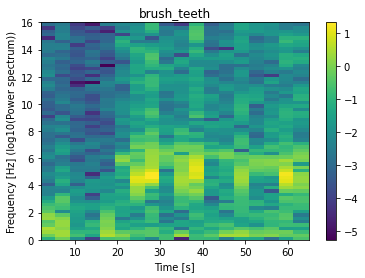

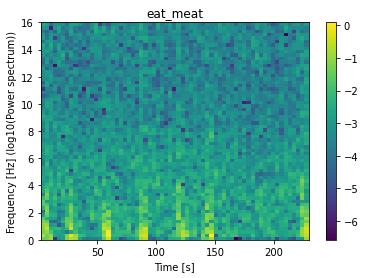

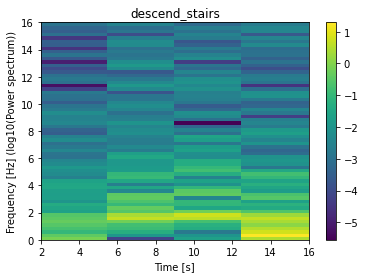

In [22]:
b.Spectrogram_plotter('brush_teeth', 2, 'X')
b.Spectrogram_plotter('eat_meat', 2, 'X')
b.Spectrogram_plotter('descend_stairs', 2, 'X')

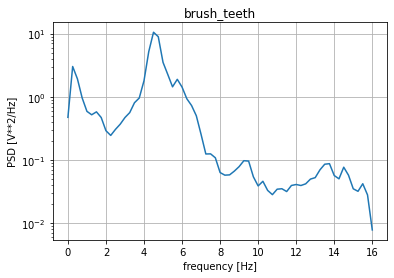

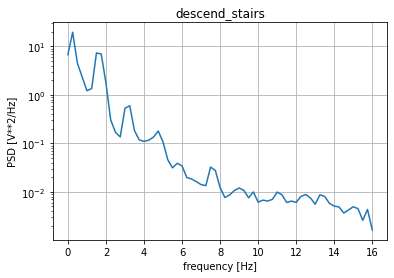

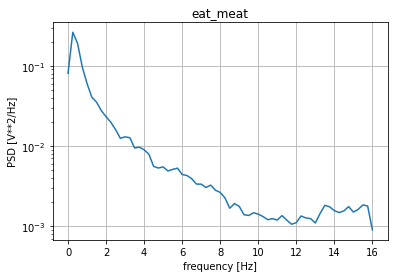

In [23]:
#print(df1[df1['date_time']=='2011-03-24-13-56-42']['Y'])
b.PSD_plotter('brush_teeth', 2, 'X')
b.PSD_plotter('descend_stairs', 2, 'X')
b.PSD_plotter('eat_meat', 2, 'X')

In [ ]:
# Models (yet to be implemented)
# link : https://github.com/qiuqiangkong/audioset_tagging_cnn/blob/master/pytorch/models.py (PANN)


class Conv2D(pl.LightningModule):
  def __init__(self, input_size, output_size):
    super(Conv2D, self).__init__()
    self.cv1 = nn.Conv2d(in_channels=input_size, out_channels=output_size,
                           kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
    self.cv2 = nn.Conv2d(in_channels=input_size, out_channels=output_size,
                           kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
    self.bn1 = nn.BatchNorm2d(output_size)
    self.bn2 = nn.BatchNorm2d(output_size)
    # doubt: initializing the weights 

  def forward(self, input, pool_size=(2, 2), pool_type='avg'):
    x = input
    x = nn.ReLU(self.bn1(self.cv1(x)))
    x = nn.ReLU(self.bn2(self.cv2(x)))
    if pool_type == 'max':
      x = nn.MaxPool2d(x, pool_size)
    elif pool_type == 'avg':
      x = nn.AvgPool2d(x, pool_size)
    elif pool_type == 'avg+max':
      x1 = nn.MaxPool2d(x, pool_size)
      x2 = nn.AvgPool2d(x, pool_size)
      x = x1 + x2 # merge and run ? 
    return x 

class CNN14(pl.LightningModule):
  def __init__(self):
    super(CNN14, self).__init__()
    # doubt: Mel filter bank and Spectrogram specs
    self.bn0 = nn.BatchNorm2d(64)
    self.conv_block1 = Conv2D(1, 64)
    self.conv_block2 = Conv2D(64, 128)
    self.conv_block3 = Conv2D(128, 256)
    self.conv_block4 = Conv2D(256, 512)
    self.conv_block5 = Conv2D(512, 1024)
    self.conv_block6 = Conv2D(1024, 2048)
    self.fc1 = nn.Linear(2048, 2048, bias=True)
    self.fc_2 = nn.Linear(2048, 14, bias=True)
    self.loss = nn.CrossEntropyLoss()

  def forward(self, x, input):
    # operations with input 

    x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
    x = nn.Dropout(x, p=0.2)
    x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
    x = nn.Dropout(x, p=0.2)
    x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
    x = nn.Dropout(x, p=0.2)
    x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
    x = nn.Dropout(x, p=0.2)
    x = self.conv_block5(x, pool_size=(2, 2), pool_type='avg')
    x = nn.Dropout(x, p=0.2)
    x = self.conv_block6(x, pool_size=(1, 1), pool_type='avg')
    x = nn.Dropout(x, p=0.2)
    # global pooling 
    x = torch.mean(x, dim=3)
    (x1, _) = torch.max(x, dim=2)
    x2 = torch.mean(x, dim=2)
    x = x1 + x2
    x = nn.dropout(x, p=0.5, training=self.training)
    x = nn.ReLU(self.fc1(x))
    clipwise_output = torch.sigmoid(self.fc_2(x))
  
  def training_step(self, batch, batch_idx): 
    x, y = batch
    x = x.reshape(x.shape[0], -1) 
    l = self(x, [batch, len(x)]) # logit 
    J = self.loss(l, y)
    self.log("train_loss", J, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return J
  
  def configure_optimizers(self):         # Optimizer
    opt = torch.optim.SGD(self.parameters(), lr = 1e-2)
    return opt
    
'''
hyperparameter tunig see: automl, grid search 
modify the CNN14 model 
'''
